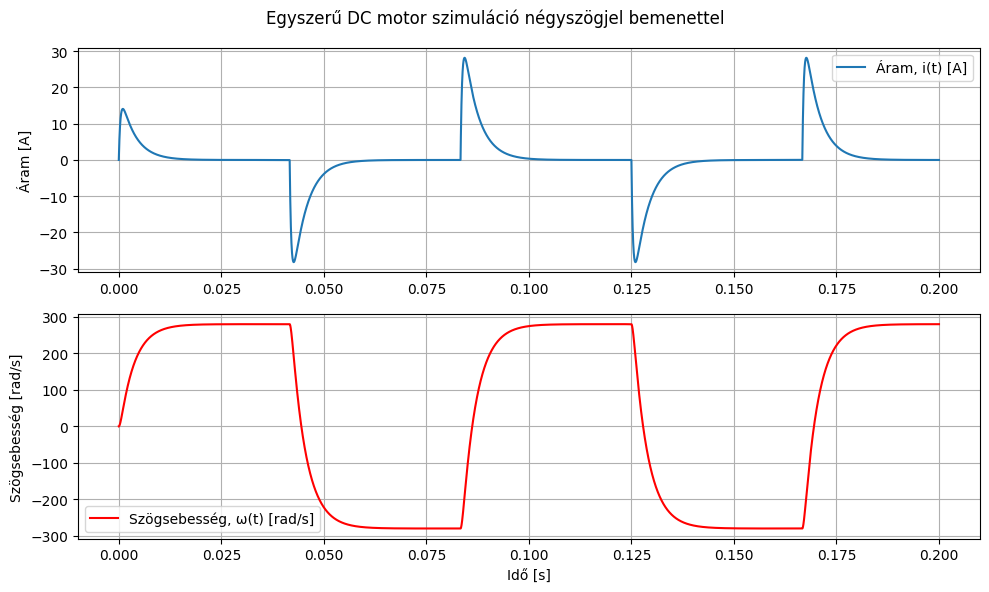

In [10]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

def square_wave(t, freq=12, V_high=12.0, V_low=-12.0):
    """
    Négyszögjel generálása.
    Paraméterek:
      - t: az aktuális idő,
      - freq: frekvencia (Hz) (0.1 Hz -> 10 s periódusidő),
      - V_high: pozitív feszültség szint,
      - V_low: negatív feszültség szint.
    Az első félperiódusban V_high, a másodikban V_low.
    """
    period = 1.0 / freq
    if (t % period) < (period / 2):
        return V_high
    else:
        return V_low

def dc_motor_ode(x, t, R, L, k, J, T_load):
    """
    DC motor modell differenciálegyenletei.
    
    Állapotvektor: x = [i, omega],
      - i: az armatúraáram [A],
      - omega: a motor szögsebessége [rad/s].
      
    Egyenletek:
      L * di/dt = u(t) - R*i - k*omega,
      J * d(omega)/dt = k*i - b*omega - T_load.
      
    A bemeneti feszültséget a square_wave() függvény generálja.
    """
    i, omega = x
    u = square_wave(t)  # Alapértelmezett frekvencia, V_high, V_low értékekkel
    di_dt = (u - R * i - k * omega) / L
    domega_dt = (k * i - T_load) / J  # Feltételezzük, hogy b=0
    return [di_dt, domega_dt]

# Motor paraméterek
R = 0.716         # ohm
L = 0.00026        # H
k = 0.0429        # Nm/A (vagy V/(rad/s))
J = 0.00001        # kg·m^2
T_load = 0.0    # Nm



# Szimulációs beállítások
t_max = 0.2   # szimulációs idő (s)
dt = 1e-6       # időlépés (s)
t_vals = np.arange(0, t_max, dt)
x0 = [0.0, 0.0]  # Kezdeti feltételek: 0 A, 0 rad/s

# Egyenletek integrálása
sol = odeint(dc_motor_ode, x0, t_vals, args=(R, L, k, J, T_load))
i_vals = sol[:, 0]
omega_vals = sol[:, 1]

# Eredmények ábrázolása
plt.figure(figsize=(10,6))

plt.subplot(2,1,1)
plt.plot(t_vals, i_vals, label="Áram, i(t) [A]")
plt.ylabel("Áram [A]")
plt.grid(True)
plt.legend()

plt.subplot(2,1,2)
plt.plot(t_vals, omega_vals, 'r', label="Szögsebesség, ω(t) [rad/s]")
plt.xlabel("Idő [s]")
plt.ylabel("Szögsebesség [rad/s]")
plt.grid(True)
plt.legend()

plt.suptitle("Egyszerű DC motor szimuláció négyszögjel bemenettel")
plt.tight_layout()
plt.show()


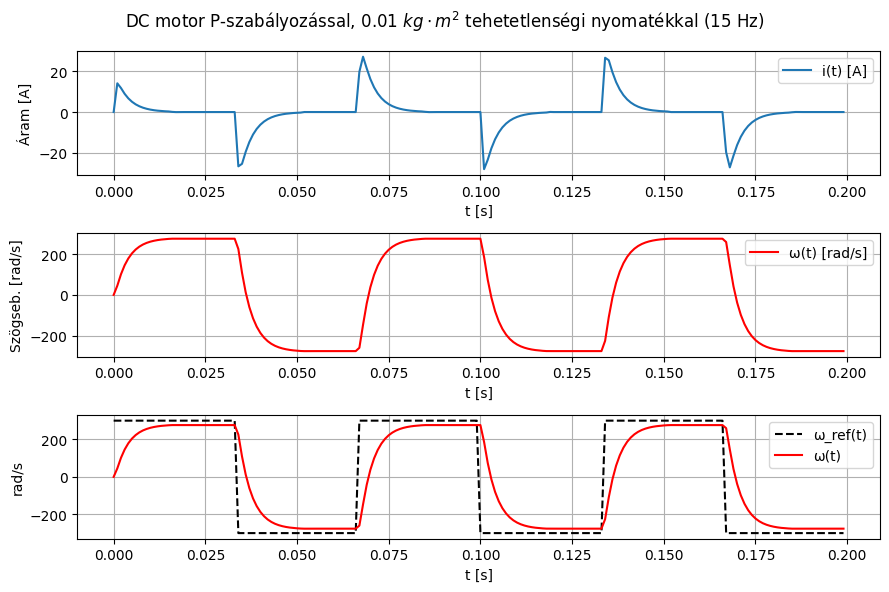

In [ ]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

def clamp(value, vmin, vmax):
    """ Egyszerű szaturációs függvény. """
    return max(vmin, min(value, vmax))

class DCMotorSquareWaveRefPControl:
    """
    DC motor P-szabályozással, amelynél a referencia
    szögsebesség (w_ref) négyszögjelként változik.
    """
    def __init__(self,
                 R=0.716,           # Armatúra ellenállás [ohm]
                 L=0.00026,          # Armatúra induktivitás [H]
                 k=0.0429,          # kϕ (Nm/A, V/(rad/s))
                 J=0.00001,          # Tehetetlenségi nyomaték [kg*m^2]
                 b=0.0,           # Viszkózus súrlódás [N*m*s/rad]
                 T_load=0.0,      # Terhelő nyomaték [Nm]
                 Kp=0.5,          # P-szabályozó erősítés
                 w_high=300.0,     # Négyszögjel "felső" szögsebesség [rad/s]
                 w_low=-300.0,       # Négyszögjel "alsó" szögsebesség [rad/s]
                 freq=5,       # Négyszög-frekvencia [Hz]
                 Vmax=12.0):      # Feszültség szaturáció ± [V]
        self.R = R
        self.L = L
        self.k = k
        self.J = J
        self.b = b
        self.T_load = T_load
        self.Kp = Kp
        self.w_high = w_high
        self.w_low = w_low
        self.freq = freq
        self.Vmax = Vmax

    def w_ref(self, t):
        """
        Négyszögjel generálása a sebességreferenciához:
        félperiódusonként w_high vagy w_low.
        """
        T = 1.0 / self.freq  # periódusidő
        if (t % T) < (T / 2.0):
            return self.w_high
        else:
            return self.w_low

    def motor_ode(self, x, t):
        """
        A motor állapotai: x = [i, omega].
        Differenciálegyenletek:
          L di/dt = u(t) - R*i - k*omega
          J d(omega)/dt = k*i - b*omega - T_load
        
        A bemenetet (u) a P-szabályozó adja:
          e = w_ref(t) - omega
          u_raw = Kp * e
          u = clamp(u_raw, -Vmax, Vmax)
        """
        i, omega = x

        # Referencia (négyszögjel) beolvasása
        w_r = self.w_ref(t)

        # Sebességhiba
        e = w_r - omega

        # P-szabályozó + szaturáció
        u_raw = self.Kp * e
        u = clamp(u_raw, -self.Vmax, self.Vmax)

        # Elektromos dinamika
        di_dt = (u - self.R*i - self.k*omega) / self.L
        # Mechanikai dinamika
        domega_dt = (self.k*i - self.b*omega - self.T_load) / self.J

        return [di_dt, domega_dt]

    def simulate(self, x0=None, t_max=10.0, dt=1e-3):
        """
        Szimuláció a t=0..t_max időintervallumon,
        dt lépésközzel. x0 = [i(0), omega(0)]
        """
        if x0 is None:
            x0 = [0.0, 0.0]

        t_vals = np.arange(0, t_max, dt)
        sol = odeint(self.motor_ode, x0, t_vals)

        i_vals = sol[:, 0]
        w_vals = sol[:, 1]
        return t_vals, i_vals, w_vals


if __name__ == "__main__":
    # Példa motorparaméterek
    motor = DCMotorSquareWaveRefPControl(
        R=0.716,           # Armatúra ellenállás [ohm]
        L=0.00026,          # Armatúra induktivitás [H]
        k=0.0429,          # kϕ (Nm/A, V/(rad/s))
        J=0.00001,          # Tehetetlenségi nyomaték [kg*m^2]
        b=0.0,           # Viszkózus súrlódás [N*m*s/rad]
        T_load=0.0,      # Terhelő nyomaték [Nm]
        Kp=0.5,          # P-szabályozó erősítés
        w_high=300.0,     # Négyszögjel "felső" szögsebesség [rad/s]
                 w_low=-300.0,       # Négyszögjel "alsó" szögsebesség [rad/s]
                 freq=15,       # Négyszög-frekvencia [Hz]
                 Vmax=12.0     # Feszültség szaturáció ± [V]
    )

    # 0.2 másodperces szimuláció, 1e-3 lépésközzel
    t_max = 0.2
    dt = 1e-3
    t, i_vals, w_vals = motor.simulate(t_max=t_max, dt=dt)

    # Ábrázoljuk a kapott eredményeket
    plt.figure(figsize=(9,6))

    # Áram
    plt.subplot(3,1,1)
    plt.plot(t, i_vals, label='i(t) [A]')
    plt.grid(True)
    plt.xlabel('t [s]')
    plt.ylabel('Áram [A]')
    plt.legend()

    # Sebesség
    plt.subplot(3,1,2)
    plt.plot(t, w_vals, 'r', label='ω(t) [rad/s]')
    plt.grid(True)
    plt.xlabel('t [s]')
    plt.ylabel('Szögseb. [rad/s]')
    plt.legend()

    # Referencia és sebesség összehasonlítás
    plt.subplot(3,1,3)
    # Kirajzoljuk a referencia négyszögjelet is
    w_ref_vals = np.array([motor.w_ref(ti) for ti in t])
    plt.plot(t, w_ref_vals, 'k--', label='ω_ref(t)')
    plt.plot(t, w_vals, 'r', label='ω(t)')
    plt.grid(True)
    plt.xlabel('t [s]')
    plt.ylabel('rad/s')
    plt.legend()

    plt.suptitle("DC motor P-szabályozással, 0.01 $kg \cdot m^2$ tehetetlenségi nyomatékkal (15 Hz)")
    plt.tight_layout()
    plt.show()

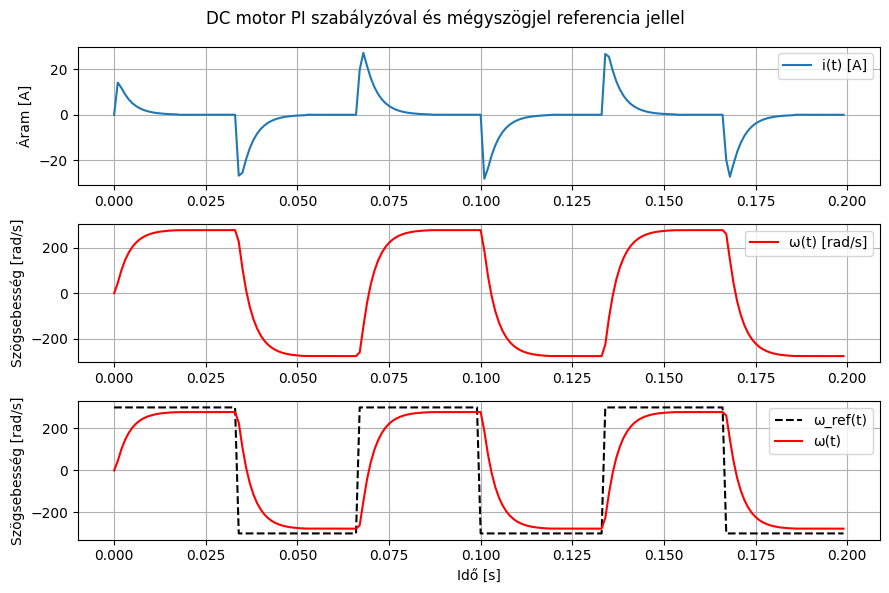

In [32]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

def clamp(value, vmin, vmax):
    """Egyszerű szaturációs függvény."""
    return max(vmin, min(value, vmax))

class DCMotorSquareWaveRefPIControl:
    """
    DC motor PI-szabályozással, ahol a referencia szögsebesség (w_ref)
    négyszögjelként változik a self.w_high, self.w_low és self.freq alapján.
    """
    def __init__(self,
                 R=0.716,         # Armatúra ellenállás [ohm]
                 L=0.00026,       # Armatúra induktivitás [H]
                 k=0.0429,        # kϕ (Nm/A, V/(rad/s))
                 J=0.00001,       # Tehetetlenségi nyomaték [kg*m^2]
                 b=0.0,           # Viszkózus súrlódás [N*m*s/rad]
                 T_load=0.0,      # Terhelő nyomaték [Nm]
                 Kp=0.5,          # P-szabályozó erősítés
                 Ki=0.5,          # I-szabályozó erősítés (példaérték)
                 w_high=300.0,    # Négyszögjel "felső" szögsebesség [rad/s]
                 w_low=-300.0,    # Négyszögjel "alsó" szögsebesség [rad/s]
                 freq=15,         # Négyszögjel frekvencia [Hz]
                 Vmax=12.0):      # Feszültség szaturáció ± [V]
        self.R = R
        self.L = L
        self.k = k
        self.J = J
        self.b = b
        self.T_load = T_load
        self.Kp = Kp
        self.Ki = Ki
        self.w_high = w_high
        self.w_low = w_low
        self.freq = freq
        self.Vmax = Vmax

    def w_ref(self, t):
        """
        Négyszögjel generálása a sebességreferenciához:
        Félperiódusonként self.w_high vagy self.w_low.
        """
        T = 1.0 / self.freq  # periódusidő
        if (t % T) < (T / 2.0):
            return self.w_high
        else:
            return self.w_low

    def motor_ode(self, x, t):
        """
        Állapotvektor: x = [i, omega, e_int],
          - i: armatúraáram [A],
          - omega: motor szögsebesség [rad/s],
          - e_int: a sebességhiba integráltja.
        
        Differenciálegyenletek:
          L di/dt = u(t) - R*i - k*omega,
          J d(omega)/dt = k*i - b*omega - T_load,
          d(e_int)/dt = w_ref(t) - omega.
        
        A szabályzó kimenetét PI szabályzás határozza meg:
          u(t) = Kp*(w_ref(t)-omega) + Ki*e_int,
        melyet ±Vmax értékre szaturálunk.
        """
        i, omega, e_int = x
        
        # Referencia jel a square-wave alapján
        ref = self.w_ref(t)
        
        # Hibaszámítás és PI szabályzás
        error = ref - omega
        u_raw = self.Kp * error + self.Ki * e_int
        u = clamp(u_raw, -self.Vmax, self.Vmax)
        
        # Elektromos dinamika
        di_dt = (u - self.R * i - self.k * omega) / self.L
        # Mechanikai dinamika
        domega_dt = (self.k * i - self.b * omega - self.T_load) / self.J
        # Az integrált hiba időderiváltja
        de_int_dt = error
        
        return [di_dt, domega_dt, de_int_dt]

    def simulate(self, x0=None, t_max=10.0, dt=1e-3):
        """
        Szimuláció a t=0..t_max időintervallumon, dt időlépésközzel.
        x0 = [i(0), omega(0), e_int(0)]
        """
        if x0 is None:
            x0 = [0.0, 0.0, 0.0]
        t_vals = np.arange(0, t_max, dt)
        sol = odeint(self.motor_ode, x0, t_vals)
        
        i_vals = sol[:, 0]
        w_vals = sol[:, 1]
        e_int_vals = sol[:, 2]
        return t_vals, i_vals, w_vals, e_int_vals


if __name__ == "__main__":
    # Példa motorparaméterek PI szabályzóval és négyszög referencia jellel
    motor = DCMotorSquareWaveRefPIControl(
        R=0.716,
        L=0.00026,
        k=0.0429,
        J=0.00001,
        b=0.0,
        T_load=0.0,
        Kp=0.5,
        Ki=0.5,         # A Ki értékét a rendszer dinamikája alapján finomhangolni kell!
        w_high=300.0,
        w_low=-300.0,
        freq=15,
        Vmax=12.0
    )

    # Szimuláció: 0.2 másodperc, 1e-3 s-es lépésközzel
    t_max = 0.2
    dt = 1e-3
    t, i_vals, w_vals, e_int_vals = motor.simulate(t_max=t_max, dt=dt)

    # Ábrázolás
    plt.figure(figsize=(9,6))

    # Áram
    plt.subplot(3,1,1)
    plt.plot(t, i_vals, label="i(t) [A]")
    plt.ylabel("Áram [A]")
    plt.grid(True)
    plt.legend()

    # Szögsebesség
    plt.subplot(3,1,2)
    plt.plot(t, w_vals, 'r', label="ω(t) [rad/s]")
    plt.ylabel("Szögsebesség [rad/s]")
    plt.grid(True)
    plt.legend()

    # Referencia jel és tényleges szögsebesség összehasonlítása
    plt.subplot(3,1,3)
    w_ref_vals = np.array([motor.w_ref(ti) for ti in t])
    plt.plot(t, w_ref_vals, 'k--', label="ω_ref(t)")
    plt.plot(t, w_vals, 'r', label="ω(t)")
    plt.xlabel("Idő [s]")
    plt.ylabel("Szögsebesség [rad/s]")
    plt.grid(True)
    plt.legend()

    plt.suptitle("DC motor PI szabályzóval és mégyszögjel referencia jellel")
    plt.tight_layout()
    plt.show()


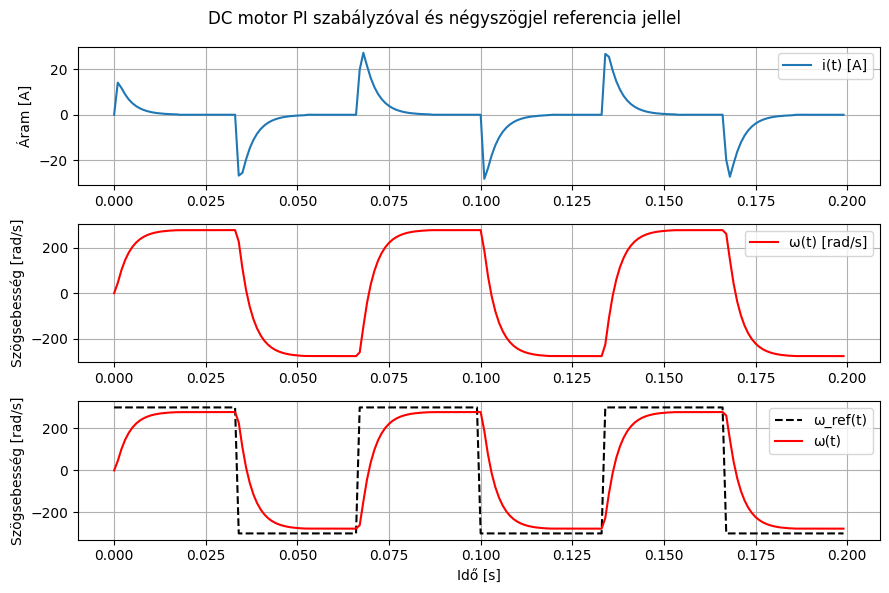

In [9]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

def clamp(value, vmin, vmax):
    """Egyszerű szaturációs függvény."""
    return max(vmin, min(value, vmax))

class DCMotorSquareWaveRefPIControl:
    """
    DC motor PI-szabályozással, ahol a referencia szögsebesség (w_ref)
    négyszögjelként változik a self.w_high, self.w_low és self.freq alapján.
    """
    def __init__(self,
                 R=0.716,         # Armatúra ellenállás [ohm]
                 L=0.00026,       # Armatúra induktivitás [H]
                 k=0.0429,        # kϕ (Nm/A, V/(rad/s))
                 J=0.00001,       # Tehetetlenségi nyomaték [kg*m^2]
                 b=0.0,           # Viszkózus súrlódás [N*m*s/rad]
                 T_load=0.0,      # Terhelő nyomaték [Nm]
                 Kp=0.5,          # P-szabályozó erősítés
                 Ki=0.5,          # I-szabályozó erősítés (példaérték)
                 w_high=300.0,    # Négyszögjel "felső" szögsebesség [rad/s]
                 w_low=-300.0,    # Négyszögjel "alsó" szögsebesség [rad/s]
                 freq=15,         # Négyszögjel frekvencia [Hz]
                 Vmax=12.0):      # Feszültség szaturáció ± [V]
        self.R = R
        self.L = L
        self.k = k
        self.J = J
        self.b = b
        self.T_load = T_load
        self.Kp = Kp
        self.Ki = Ki
        self.w_high = w_high
        self.w_low = w_low
        self.freq = freq
        self.Vmax = Vmax

    def w_ref(self, t):
        """
        Négyszögjel generálása a sebességreferenciához:
        Félperiódusonként self.w_high vagy self.w_low.
        """
        T = 1.0 / self.freq  # periódusidő
        if (t % T) < (T / 2.0):
            return self.w_high
        else:
            return self.w_low

    def motor_ode(self, x, t):
        """
        Állapotvektor: x = [i, omega, e_int],
          - i: armatúraáram [A],
          - omega: motor szögsebesség [rad/s],
          - e_int: a sebességhiba integráltja.
        
        Differenciálegyenletek:
          L di/dt = u(t) - R*i - k*omega,
          J d(omega)/dt = k*i - b*omega - T_load,
          d(e_int)/dt = w_ref(t) - omega.
        
        A szabályzó kimenetét PI szabályzás határozza meg:
          u(t) = Kp*(w_ref(t)-omega) + Ki*e_int,
        melyet ±Vmax értékre szaturálunk.
        """
        i, omega, e_int = x
        
        # Referencia jel a square-wave alapján
        ref = self.w_ref(t)
        
        # Hibaszámítás és PI szabályzás
        error = ref - omega
        u_raw = self.Kp * error + self.Ki * e_int
        u = clamp(u_raw, -self.Vmax, self.Vmax)
        
        # Elektromos dinamika
        di_dt = (u - self.R * i - self.k * omega) / self.L
        # Mechanikai dinamika
        domega_dt = (self.k * i - self.b * omega - self.T_load) / self.J
        # Az integrált hiba időderiváltja
        de_int_dt = error
        
        return [di_dt, domega_dt, de_int_dt]

    def simulate(self, x0=None, t_max=10.0, dt=1e-3):
        """
        Szimuláció a t=0..t_max időintervallumon, dt időlépésközzel.
        x0 = [i(0), omega(0), e_int(0)]
        """
        if x0 is None:
            x0 = [0.0, 0.0, 0.0]
        t_vals = np.arange(0, t_max, dt)
        sol = odeint(self.motor_ode, x0, t_vals)
        
        i_vals = sol[:, 0]
        w_vals = sol[:, 1]
        e_int_vals = sol[:, 2]
        return t_vals, i_vals, w_vals, e_int_vals


if __name__ == "__main__":
    # Példa motorparaméterek PI szabályzóval és négyszög referencia jellel
    motor = DCMotorSquareWaveRefPIControl(
        R=0.716,
        L=0.00026,
        k=0.0429,
        J=0.00001,
        b=0.0,
        T_load=0.0,
        Kp=0.5,
        Ki=0.5,         # A Ki értékét a rendszer dinamikája alapján finomhangolni kell!
        w_high=300.0,
        w_low=-300.0,
        freq=15,
        Vmax=12.0
    )

    # Szimuláció: 0.2 másodperc, 1e-3 s-es lépésközzel
    t_max = 0.2
    dt = 1e-3
    t, i_vals, w_vals, e_int_vals = motor.simulate(t_max=t_max, dt=dt)

    # Ábrázolás
    plt.figure(figsize=(9,6))

    # Áram
    plt.subplot(3,1,1)
    plt.plot(t, i_vals, label="i(t) [A]")
    plt.ylabel("Áram [A]")
    plt.grid(True)
    plt.legend()

    # Szögsebesség
    plt.subplot(3,1,2)
    plt.plot(t, w_vals, 'r', label="ω(t) [rad/s]")
    plt.ylabel("Szögsebesség [rad/s]")
    plt.grid(True)
    plt.legend()

    # Referencia jel és tényleges szögsebesség összehasonlítása
    plt.subplot(3,1,3)
    w_ref_vals = np.array([motor.w_ref(ti) for ti in t])
    plt.plot(t, w_ref_vals, 'k--', label="ω_ref(t)")
    plt.plot(t, w_vals, 'r', label="ω(t)")
    plt.xlabel("Idő [s]")
    plt.ylabel("Szögsebesség [rad/s]")
    plt.grid(True)
    plt.legend()

    plt.suptitle("DC motor PI szabályzóval és négyszögjel referencia jellel")
    plt.tight_layout()
    plt.show()


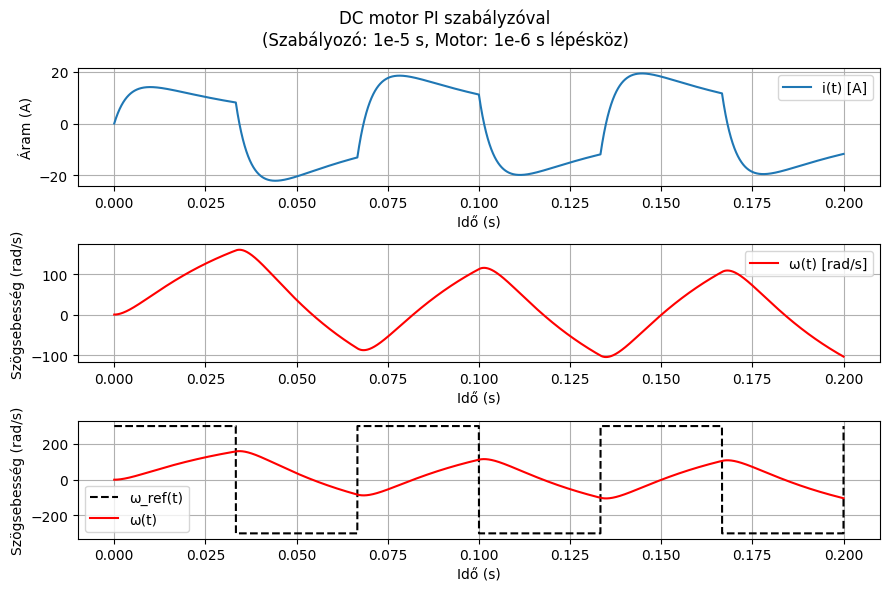

In [31]:
import numpy as np
import matplotlib.pyplot as plt

def clamp(value, vmin, vmax):
    """Egyszerű szaturációs függvény."""
    return max(vmin, min(value, vmax))

class DCMotorSquareWaveRefPIControl:
    """
    DC motor PI szabályozóval, ahol a referencia jel (w_ref)
    négyszögjelként változik a self.w_high, self.w_low és self.freq alapján.
    
    A motor dinamikáját 1e-6 s-es időlépésközzel integráljuk, míg a PI szabályozó
    1e-2 s-es időközönként avatkozik be.
    """
    def __init__(self,
                 R=0.716,         # Armatúra ellenállás [ohm]
                 L=0.00026,       # Armatúra induktivitás [H]
                 k=0.0429,        # kϕ (Nm/A, V/(rad/s))
                 J=0.00001,       # Tehetetlenségi nyomaték [kg*m^2]
                 b=0.0,           # Viszkózus súrlódás [N*m*s/rad]
                 T_load=0.0,      # Terhelő nyomaték [Nm]
                 Kp=0.5,          # P-szabályozó erősítés
                 Ki=0.1,          # I-szabályozó erősítés (példaérték)
                 w_high=300.0,    # Négyszögjel "felső" szögsebesség [rad/s]
                 w_low=-300.0,    # Négyszögjel "alsó" szögsebesség [rad/s]
                 freq=5,          # Négyszög-frekvencia [Hz]
                 Vmax=12.0):      # Feszültség szaturáció ± [V]
        self.R = R
        self.L = L
        self.k = k
        self.J = J
        self.b = b
        self.T_load = T_load
        self.Kp = Kp
        self.Ki = Ki
        self.w_high = w_high
        self.w_low = w_low
        self.freq = freq
        self.Vmax = Vmax

    def w_ref(self, t):
        """
        Négyszögjel generálása a sebességreferenciához:
        Félperiódusonként self.w_high vagy self.w_low.
        """
        T = 1.0 / self.freq
        if (t % T) < (T / 2.0):
            return self.w_high
        else:
            return self.w_low

    def simulate(self, x0=None, t_max=0.2, dt_controller=1e-2, dt_motor=1e-6):
        """
        Szimuláció a t = 0 .. t_max időintervallumon.
        
        x0: kezdeti állapot [i, omega, e_int] (áram, szögsebesség, integrált hiba)
        dt_controller: a PI szabályozó időköze (0.01 s)
        dt_motor: a motor integrációs időlépés (1e-6 s)
        
        A szabályozó minden dt_controller időközönként számolja ki a vezérlő feszültséget,
        melyet az azt követő dt_motor lépések alatt állandónak feltételezünk.
        """
        if x0 is None:
            x0 = [0.0, 0.0, 0.0]  # [i, omega, e_int]
        
        t = 0.0
        times = [t]
        i_vals = [x0[0]]
        omega_vals = [x0[1]]
        e_int_vals = [x0[2]]
        
        x = x0.copy()
        while t < t_max:
            current_time = t
            # Számoljuk ki a referencia jelet a controller frissítés idején
            w_r = self.w_ref(current_time)
            # Hibaszámítás: referencia - aktuális szögsebesség
            error = w_r - x[1]
            # PI szabályozás: u = Kp * error + Ki * integrált hiba
            u_raw = self.Kp * error + self.Ki * x[2]
            u = clamp(u_raw, -self.Vmax, self.Vmax)
            
            # A PI szabályozó kimenete állandó a következő dt_controller időszak alatt
            steps = int(dt_controller / dt_motor)
            for _ in range(steps):
                i, omega, e_int = x
                # Elektromos dinamika
                di_dt = (u - self.R * i - self.k * omega) / self.L
                # Mechanikai dinamika
                domega_dt = (self.k * i - self.b * omega - self.T_load) / self.J
                # Az integrált hiba deriváltja: hiba (itt a controller frissítéskor számolt)
                de_int_dt = error
                
                # Euler integráció a motor állapotára
                i += di_dt * dt_motor
                omega += domega_dt * dt_motor
                e_int += de_int_dt * dt_motor
                t += dt_motor
                
            x = [i, omega, e_int]
            times.append(t)
            i_vals.append(i)
            omega_vals.append(omega)
            e_int_vals.append(e_int)
            
        return np.array(times), np.array(i_vals), np.array(omega_vals), np.array(e_int_vals)

if __name__ == "__main__":
    motor = DCMotorSquareWaveRefPIControl(
        R=0.716,
        L=0.00026,
        k=0.0429,
        J=0.00001,
        b=0.0,
        T_load=0.0,
        Kp=0.5,
        Ki=0.1,        # PI szabályzó I tagjának példaértéke
        w_high=300.0,
        w_low=-300.0,
        freq=15,
        Vmax=12.0
    )

    # Szimuláció: 0.2 másodperc, controller 1e-2 s-es, motor 1e-6 s-es lépésközzel
    t_max = 0.2
    dt_controller = 1e-5
    dt_motor = 1e-6
    times, i_vals, omega_vals, e_int_vals = motor.simulate(t_max=t_max, dt_controller=dt_controller, dt_motor=dt_motor)
    
    # Ábrázolás
    plt.figure(figsize=(9,6))
    
    plt.subplot(3,1,1)
    plt.plot(times, i_vals, label="i(t) [A]")
    plt.xlabel("Idő (s)")
    plt.ylabel("Áram (A)")
    plt.grid(True)
    plt.legend()
    
    plt.subplot(3,1,2)
    plt.plot(times, omega_vals, 'r', label="ω(t) [rad/s]")
    plt.xlabel("Idő (s)")
    plt.ylabel("Szögsebesség (rad/s)")
    plt.grid(True)
    plt.legend()
    
    plt.subplot(3,1,3)
    w_ref_vals = np.array([motor.w_ref(t) for t in times])
    plt.plot(times, w_ref_vals, 'k--', label="ω_ref(t)")
    plt.plot(times, omega_vals, 'r', label="ω(t)")
    plt.xlabel("Idő (s)")
    plt.ylabel("Szögsebesség (rad/s)")
    plt.grid(True)
    plt.legend()
    
    plt.suptitle("DC motor PI szabályzóval\n(Szabályozó: 1e-5 s, Motor: 1e-6 s lépésköz)")
    plt.tight_layout()
    plt.show()


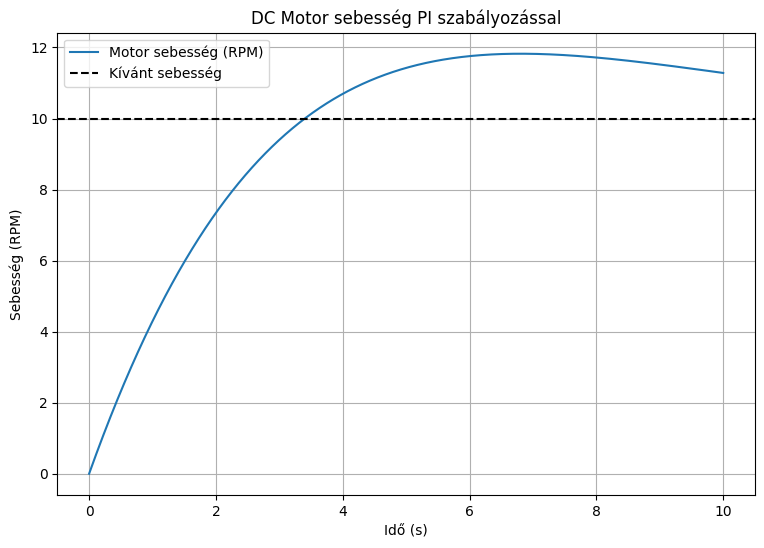

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# Paraméterek
setpoint = 10  # kívánt motorsebesség (RPM)
Kp = 0.5        # arányos erősítés
Ki = 0.1       # integrális erősítés

sim_time = 10     # szimulációs idő (s) 
dt_controller = 1e-3  # PI szabályozó frissítési időköze (s)
dt_motor = 1e-6       # motor integrációs időlépés (s)

# Kezdeti feltételek
motor_speed = 0.0  # kezdeti motorsebesség (RPM)
integral = 0.0     # integrált hiba

# Adatok tárolása az ábrázoláshoz
time_data = []
speed_data = []

t = 0.0
while t < sim_time:
    # Controller frissítés (1e-3 s-es időközönként)
    error = setpoint - motor_speed
    # Az integrált hibát a controller periódusának időközével frissítjük
    integral += error * dt_controller
    control_output = Kp * error + Ki * integral

    # A kiszámolt control_output-ot alkalmazzuk a következő dt_controller időszakban
    steps = int(dt_controller / dt_motor)  # lépések száma controller ciklus alatt (kb. 1000)
    for _ in range(steps):
        # Egyszerű, lineáris motor modell: motor_speed változik a vezérlő kimenet hatására
        motor_speed += control_output * dt_motor
        t += dt_motor
        time_data.append(t)
        speed_data.append(motor_speed)

# Ábrázolás
plt.figure(figsize=(9,6))
plt.plot(time_data, speed_data, label="Motor sebesség (RPM)")
plt.axhline(setpoint, color='k', linestyle='--', label="Kívánt sebesség")
plt.title("DC Motor sebesség PI szabályozással")
plt.xlabel("Idő (s)")
plt.ylabel("Sebesség (RPM)")
plt.grid(True)
plt.legend()
plt.show()


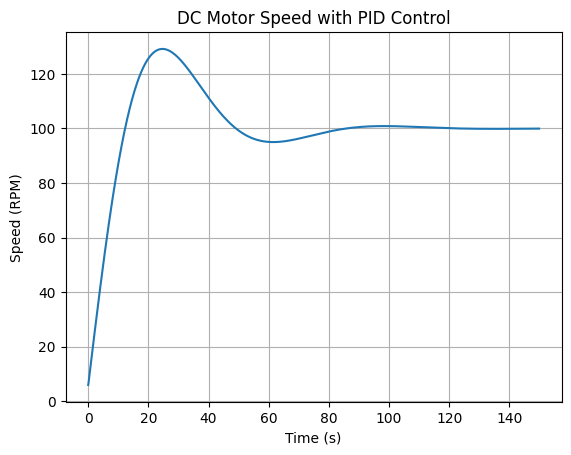

In [3]:
import matplotlib.pyplot as plt
import numpy as np

setpoint = 100  # Desired motor speed (RPM)
Kp = 0.1        # Proportional gain
Ki = 0.01       # Integral gain
Kd = 0.05       # Derivative gain
dt = 0.1        # Time step for simulation (seconds)
sim_time = 150   # Total simulation time (seconds)


integral = 0
previous_error = 0

motor_speed = 0  # Initial motor speed (RPM)

# Store data for plotting
time_data = []
speed_data = []
integral = 0
previous_error = 0

motor_speed = 0  # Initial motor speed (RPM)

# Store data for plotting
time_data = []
speed_data = []

for t in np.arange(0, sim_time, dt):
    # Calculate error between setpoint and current motor speed
    error = setpoint - motor_speed

    # Proportional term
    P_out = Kp * error
    
    # Integral term (accumulation of past errors)
    integral += error * dt
    I_out = Ki * integral
    
    # Derivative term (rate of change of error)
    derivative = (error - previous_error) / dt
    D_out = Kd * derivative

 # Calculate the total control output
    control_output = P_out + I_out + D_out
    
    # Simulate the motor speed response (simplified linear response)
    motor_speed += control_output * dt

# Update the previous error for the next iteration
    previous_error = error
    
    # Save data for plotting
    time_data.append(t)
    speed_data.append(motor_speed)


# Plot the motor speed over time
plt.plot(time_data, speed_data)
plt.title('DC Motor Speed with PID Control')
plt.xlabel('Time (s)')
plt.ylabel('Speed (RPM)')
plt.grid(True)
plt.show()

[2, 3, 4, 5, 6]
